In [30]:
# resources:
# https://earthquake.usgs.gov/fdsnws/event/1/   API


In [31]:
import requests
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [32]:
# open session and explore the api
session = requests.Session()
URL = "https://earthquake.usgs.gov/fdsnws/event/1/application.json"

response = session.get(url=URL)
data = response.json()

print(data.keys())
for key in data.keys():
    print(random.sample(data[key], 10))

dict_keys(['catalogs', 'contributors', 'producttypes', 'eventtypes', 'magnitudetypes'])
['ew', 'is', 'cidev', 'cgs', 'pags', 'ld', 'official19631013051759_30', 'nm', 'at', 'nc']
['uw', 'ok', 'ci', 'av', 'prod01-pdl01.cr.usgs.gov', 'tx', 'pr', 'ew', 'pt', 'ld']
['internal-moment-tensor', 'poster', 'cap', 'disassociate', 'heartbeat', 'origin', 'scitech-link', 'moreinformation', 'trump-moment-tensor', 'image']
['sonicboom', 'sonic_boom', 'other event', 'meteorite', 'other', 'experimental explosion', 'meteor', 'snow avalanche', 'chemical explosion', 'quarry']
['md', 'mb', 'no', 'mwc', 'ml', 'mww', 'ms_vx', 'mfa', 'Mt', 'ms_20']


In [33]:
# let's get some actual earthquake data
URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"
PARAMS = {
    "eventtype":"earthquake",
    "format":"geojson"
}
response = session.get(url=URL, params=PARAMS)
data = response.json()

print(data.keys())
print(data["metadata"])
print(random.sample(data["features"], 3))
print(len(data["features"]))

dict_keys(['type', 'metadata', 'features', 'bbox'])
{'generated': 1700245007000, 'url': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventtype=earthquake&format=geojson', 'title': 'USGS Earthquakes', 'status': 200, 'api': '1.14.0', 'count': 9672}
[{'type': 'Feature', 'properties': {'mag': 3, 'place': '128 km NNW of Ambler, Alaska', 'time': 1698448245334, 'updated': 1700186288040, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/ak023dsizc2t', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=ak023dsizc2t&format=geojson', 'felt': None, 'cdi': None, 'mmi': None, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 138, 'net': 'ak', 'code': '023dsizc2t', 'ids': ',us7000l70w,ak023dsizc2t,', 'sources': ',us,ak,', 'types': ',origin,phase-data,', 'nst': None, 'dmin': None, 'rms': 0.65, 'gap': None, 'magType': 'ml', 'type': 'earthquake', 'title': 'M 3.0 - 128 km NNW of Ambler, Alaska'}, 'geometry': {'type': 'Point', 'coordinates': [-158.6913, 68

In [34]:
# writing it to a json file to look at it
json_string = json.dumps(data["features"], indent=4)
with open("test_request.json", "w") as outfile:
    outfile.write(json_string)

In [35]:
# load json string into a python object
data = json.loads(json_string)

# extract properties and coordinates
properties_list = [item['properties'] for item in data]
coordinates_list = [item['geometry']['coordinates'] for item in data]

# create dfs
properties_df = pd.DataFrame(properties_list)
coordinates_df = pd.DataFrame(coordinates_list, columns=['longitude', 'latitude', 'altitude'])

# concatenate dataframes along columns
result_df = pd.concat([properties_df, coordinates_df], axis=1)

# display resulting df
print(result_df.describe())

               mag          time       updated          felt         cdi  \
count  9672.000000  9.672000e+03  9.672000e+03    576.000000  576.000000   
mean      1.638290  1.698832e+12  1.699188e+12     39.585069    2.750347   
std       1.259417  7.196684e+08  6.956032e+08    503.024605    1.416438   
min      -1.320000  1.697654e+12  1.697656e+12      0.000000    0.000000   
25%       0.840000  1.698220e+12  1.698675e+12      1.000000    2.000000   
50%       1.420000  1.698752e+12  1.699296e+12      1.000000    2.700000   
75%       2.070000  1.699446e+12  1.699768e+12      5.000000    3.600000   
max       7.100000  1.700243e+12  1.700245e+12  11940.000000    8.200000   

              mmi      tsunami          sig          nst         dmin  \
count  128.000000  9672.000000  9672.000000  7611.000000  6028.000000   
mean     3.612789     0.000827    66.107113    23.481540     0.635626   
std      1.757914     0.028749    97.604225    22.582738     2.194032   
min      0.000000     0

In [36]:
# i'm comparing with the file to see if we created the dfs correctly
print(result_df.head())

    mag                           place           time        updated    tz  \
0  1.24       2 km E of The Geysers, CA  1700242603910  1700243110366  None   
1  1.40      16 km SW of Willow, Alaska  1700242037743  1700242402128  None   
2  0.70     10 km NW of The Geysers, CA  1700241923070  1700242391302  None   
3  0.73      2 km NE of The Geysers, CA  1700241407890  1700241910251  None   
4  1.60  22 km WSW of Anchorage, Alaska  1700240140234  1700240290503  None   

                                                 url  \
0  https://earthquake.usgs.gov/earthquakes/eventp...   
1  https://earthquake.usgs.gov/earthquakes/eventp...   
2  https://earthquake.usgs.gov/earthquakes/eventp...   
3  https://earthquake.usgs.gov/earthquakes/eventp...   
4  https://earthquake.usgs.gov/earthquakes/eventp...   

                                              detail  felt  cdi  mmi  ...  \
0  https://earthquake.usgs.gov/fdsnws/event/1/que...   NaN  NaN  NaN  ...   
1  https://earthquake.usgs.gov/fds

In [37]:
# delete some unused variables
del properties_df, properties_list, coordinates_df, coordinates_list
df = result_df
del result_df

In [38]:
# now let's do some more clean up
# i think we can drop place since we have the coordinates and those are universally comparable, which those place strings are not
# drop updated
# tz is none everywhere, i can't find in the docu what it even is
# url and detail are quasi redundant, we're dropping url
# idk what net is, i can't find it in the docu. should we drop it? but it's the same as sources just without the ticks. i think we should drop source as well as types, type, title
df = df.drop(columns = ["place", "updated", "tz", "url", "sources", "types", "title"])

In [39]:
df["status"].unique()
# can be reduced to boolean

array(['automatic', 'reviewed'], dtype=object)

In [40]:
df["alert"].unique()
# alert needs to be differently encoded

array([None, 'green', 'yellow'], dtype=object)

In [41]:
df["magType"].unique()
# omg are there different magnitude types? let's one_hot encode these and see how it works. maybe we'll need to convert them somehow to have a common unit but idk yet
# https://www.usgs.gov/programs/earthquake-hazards/magnitude-types

array(['md', 'ml', 'ml(texnet)', 'mb', 'mww', 'mlv', 'mb_lg', 'mwr', 'mw',
       'mwb'], dtype=object)

In [42]:
print(df[df["tsunami"] == 1]["ids"].count())
print(df[df["tsunami"] == 0]["ids"].count())
# very serious class imbalance. BUT it's probably just more likely that no tsunami occurs, luckily

8
9664


In [43]:
# TODO ststus boolean
# TODO onehot encode alert. note that there are more options than we see in our sample (green, yellow, orange, red, none)
# TODO reserach and decide what to do with magtype

/home/wallace/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


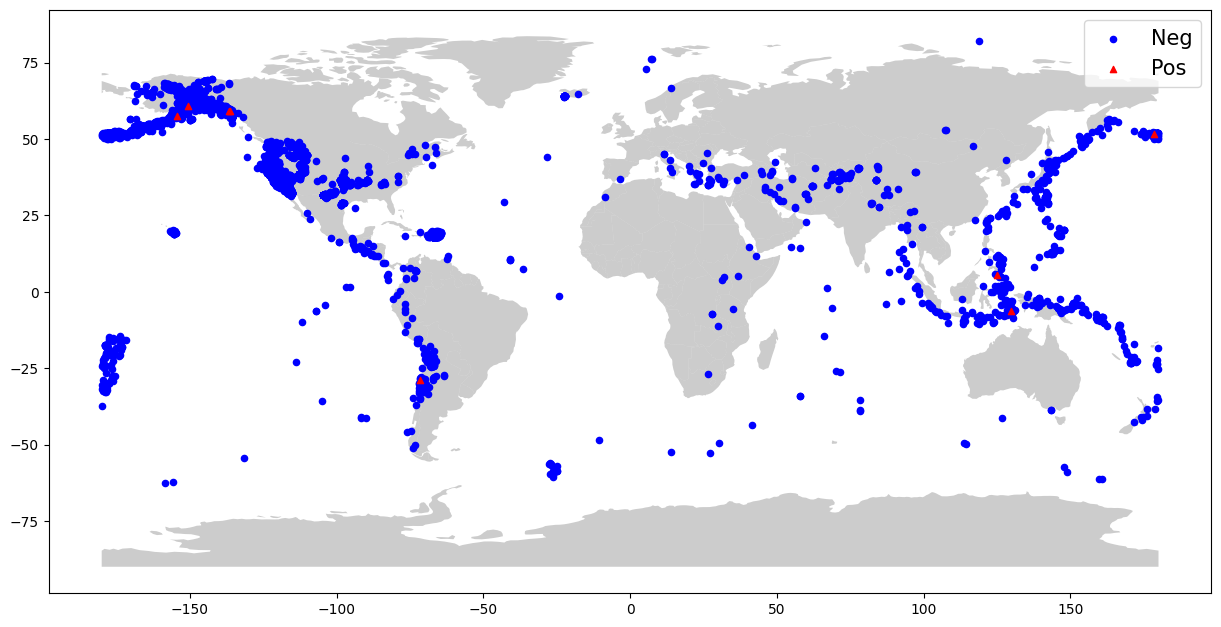

In [44]:
# visualisation
map = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(15,15))
map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['tsunami'] == 0].plot(ax=ax, 
                                       markersize=20, 
                                       color='blue', 
                                       marker='o', 
                                       label='Neg')
geo_df[geo_df['tsunami'] == 1].plot(ax=ax, 
                                       markersize=20, 
                                       color='red', 
                                       marker='^', 
                                       label='Pos')
plt.legend(prop={'size':15})

In [45]:
# also, those are just like 10000 rows. this is little data. let's get some more.
# but i think before we do that it's time to make a remote mongo db instance and store our stuff because i cannot handle tons of data on this machine
# we'll have to make json strings from our dfs, i think, and then store them in mongo